In [215]:
import EITfunc.EITlook as eit

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import matplotlib.cm as cmx
import matplotlib.colorbar as cb
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

import os

from astropy import units as u
from astropy.constants import G
from astropy.io import ascii, fits
from astropy.table import Table
from astropy.timeseries import LombScargle
import astropy.time

import scipy.optimize as sciop
from scipy.stats import mode, binned_statistic
from scipy.signal import ricker, cwt, find_peaks_cwt, morlet2, find_peaks

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
jan1_1996 = '1996-01-01T00:00:00.000Z'
jan1_1996 = astropy.time.Time(jan1_1996).jd
print(jan1_1996)

jan1_2011 = '2011-01-01T00:00:00.000Z'
jan1_2011 = astropy.time.Time(jan1_2011).jd
print(jan1_2011)

2450083.5
2455562.5


In [36]:
dayspermonth = [31,28,31,30,31,30,31,31,30,31,30,31,0]
months = [r'Jan',r'Feb',r'Mar',r'Apr',r'May',r'June',r'July',r'Aug',r'Sept',r'Oct',r'Nov',r'Dec','']
# all years divisible by 4 during SOHO are leap years, including 2000

# load EIT

In [37]:
darkImgData =np.loadtxt("./EIT/darkImgFluxes_nobakeout.txt")
print(np.shape(darkImgData))

results = np.genfromtxt("./EIT/EITresults/EIT_LC_withflags.txt")
print(np.shape(results))

(2463, 3)
(91883, 7)


In [38]:
metadata = Table.read("./EIT/EITresults/EIT_headerMetadata.txt",format="ascii")
print(metadata.colnames)

['DATE-BEG', 'DATE-AVG', 'XPOSURE', 'CMDXPOS', 'SHUTCLS', 'FILTER', 'WAVELNTH', 'OBJECT', 'SCI_OBJ', 'OBS_PROG', 'CMP_NO', 'UCD', 'EXPMODE', 'LYNESYNC', 'ROUTPORT', 'NLEBPROC', 'LEBPROC1', 'LEBPROC2', 'LEBPROC3', 'WCSNAME', 'CTYPE1', 'CTYPE2', 'CUNIT1', 'CUNIT2', 'PC1_1', 'PC1_2', 'PC2_1', 'PC2_2', 'CDELT1', 'CDELT2', 'CRVAL1', 'CRVAL2', 'CRPIX1', 'CRPIX2', 'CROTA', 'CFTEMP', 'CCDTEMP', 'SOLAR_B0', 'RSUN_ARC', 'RSUN_OBS', 'RSUN_REF', 'CAR_ROT', 'DSUN_OBS', 'SC_X0', 'SC_Y0', 'SC_ROLL', 'HAEX_OBS', 'HAEY_OBS', 'HAEZ_OBS']


In [39]:
medDist = np.median(results[:,1])*u.m
print(medDist)
print(medDist.to(u.AU))

AUinm = (u.AU.to(u.m))
print(AUinm)

148114320263.0 m
0.9900830778535941 AU
149597870700.0


In [40]:
# restrict to after commissioning was completed on Apr 16, 1996
postCommissioningMask = (results[:,0] >= 2450190.)
results = results[postCommissioningMask]
metadata = metadata[postCommissioningMask]

ts = results[:,0]                               # average date of observation
dists = results[:,1]                            # heliocentric distance in meters
ws = results[:,2].astype(float)                 # wavelength of observation
fs = results[:,3] * (dists/AUinm)               # normalize flux to heliocentric distance of 1AU
us = results[:,4] * (dists/AUinm)               # normalize flux uncertainty to heliocentric distance of 1AU
ps = results[:,5]                               # pinhole flag (==1 if Yes; can only ==1 if the Al_+1 filter was not used)
ces = results[:,6]                              # cameraError flag (==1 if Yes; still not clear exactly what this means)

m171 = (ws == 171.) 
m195 = (ws == 195.) 
m284 = (ws == 284.) 
m304 = (ws == 304.) 
wmasks = [m304,m284,m195,m171]

noPinholes = (ps == 0)
noCameraErrors = (ces == 0)


In [41]:
bakeoutDates = Table.read("./EIT/EITbakeoutDates.txt", format="ascii.basic")
bakeoutDates['jd'] = 0.

for i in range(len(bakeoutDates)):
    date = str(bakeoutDates['date_beg'][i])
    time = str(bakeoutDates['time_beg'][i]).zfill(5)

    y = int(date.split("/")[0])
    m = int(date.split("/")[1])
    d = int(date.split("/")[2])

    h = int(time.split(":")[0])
    min = int(time.split(":")[1])
    
    bakeoutDates[i]['jd'] = np.round(astropy.time.Time({'year':y, 'month':m, 'day':d, 'hour':h, 'minute':min}).jd,3)
    

heaterOnMask = (bakeoutDates['status'] == 'heaterOn')
heaterOffMask = (bakeoutDates['status'] == 'heaterOff')

heaterOn = bakeoutDates[heaterOnMask]
heaterOff = bakeoutDates[heaterOffMask]
print(heaterOn)
print(heaterOff)

 status   date_beg  time_beg dur[h]      jd    
-------- ---------- -------- ------ -----------
heaterOn 1996/05/23    19:21   45.0 2450227.306
heaterOn 1996/06/23    19:10   24.0 2450258.299
heaterOn 1996/07/23    15:48    2.5 2450288.158
heaterOn 1996/08/05    18:50   15.0 2450301.285
heaterOn 1996/08/09    15:05   71.5 2450305.128
heaterOn 1996/09/06    19:49  236.0 2450333.326
heaterOn 1996/12/19    13:14    2.5 2450437.051
heaterOn  1997/01/3    21:50  156.0  2450452.41
heaterOn 1997/02/20    21:57   13.0 2450500.415
heaterOn 1997/03/21    14:26   70.5 2450529.101
heaterOn 1997/07/18    13:30  210.0 2450648.062
heaterOn 1997/11/28    23:00   76.0 2450781.458
heaterOn 1998/03/20    16:35   72.4 2450893.191
heaterOn 1998/04/10    22:00   72.0 2450914.417
     ...        ...      ...    ...         ...
heaterOn  2012/07/2    14:30  153.5 2456111.104
heaterOn 2013/06/21    10:20  230.0 2456464.931
heaterOn 2013/12/18    14:00  279.0 2456645.083
heaterOn 2014/06/13    03:05  253.0 2456

In [42]:
# Eliminate all data points that fall within bakeout periods.
withinBakeout = np.zeros_like(ts).astype(bool)

for i in range(81):
    bakeoutStartDate = heaterOn[i]['jd']
    bakeoutEndDate = heaterOff[i]['jd']

    withinBakeoutMask = (ts > bakeoutStartDate) & (ts < bakeoutEndDate)
    withinBakeout[withinBakeoutMask] = True


# load SEM

In [43]:
# normalized by heliocentric distance
SEM = Table.read("./CELIAS-SEM/SEMDailyData_norm.txt",format="ascii")
print(SEM.colnames)
SEM_postCommissioningMask = (SEM['t_obs[JD]'] >= 2450190.)
SEM = SEM[SEM_postCommissioningMask]


['t_obs[JD]', 'firstOrderFlux[counts/s]', 'firstOrderFluxUnc[counts/s]', 'centralOrderFlux[counts/s]', 'centralOrderFluxUnc[counts/s]']


# Arrays to plot

In [44]:
cs = ['r', '#fdca40', '#41ad49', '#3772ff']
labels =['304','284','195','171']

wmask_304 = wmasks[0] & noPinholes & ~withinBakeout
t304 = ts[wmask_304]
f304 = fs[wmask_304]
u304 = us[wmask_304]

wmask_284 = wmasks[1] & noPinholes & ~withinBakeout
t284 = ts[wmask_284]
f284 = fs[wmask_284]
u284 = us[wmask_284]

wmask_195 = wmasks[2] & noPinholes & ~withinBakeout
t195 = ts[wmask_195]
f195 = fs[wmask_195]
u195 = us[wmask_195]

wmask_171 = wmasks[3] & noPinholes & ~withinBakeout
t171 = ts[wmask_171]
f171 = fs[wmask_171]
u171 = us[wmask_171]

tSEM = np.array(SEM['t_obs[JD]'])
fSEM = np.array(SEM['firstOrderFlux[counts/s]'])
uSEM = np.array(SEM['firstOrderFluxUnc[counts/s]'])


# Use the ratio of flux in the EIT 304 band to flux in the SEM narrow band to identify and mask "snowy" frames (where, I believe, solar wind is affecting the EIT CCD)

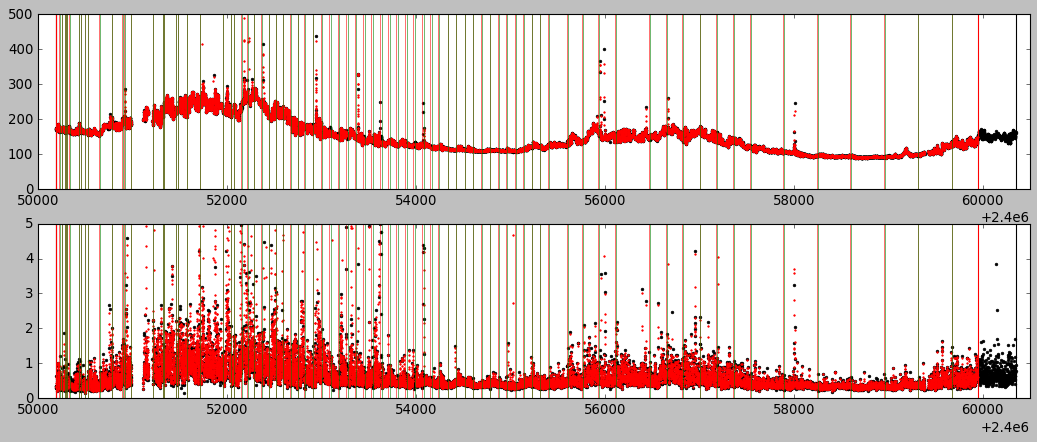

In [45]:
fSEM_interp_304 = np.interp(t304, tSEM, fSEM)
uSEM_interp_304 = np.interp(t304, tSEM, uSEM)

fig, axes = plt.subplots(2,1,figsize=(16,6))
axes[0].plot(tSEM, fSEM, 'k.',ms=5)
axes[0].plot(t304, fSEM_interp_304, 'r.',ms=3)
axes[0].set_ylim(0,500)

axes[1].plot(tSEM, uSEM, 'k.',ms=5)
axes[1].plot(t304, uSEM_interp_304, 'r.',ms=3)
axes[1].set_ylim(0,5)

for ax in axes:
    ax.set_xlim(2450000,2460500)
    ax.axvline(tSEM[0], color='k')
    ax.axvline(tSEM[-1], color='k')

    ax.axvline(t304[0], color='r')
    ax.axvline(t304[-1], color='r')
    for i in range(81):
        bakeoutStartDate = heaterOn[i]['jd']
        bakeoutEndDate = heaterOff[i]['jd']

        ax.axvline(bakeoutStartDate,color='r',linestyle='-',lw=0.5)
        ax.axvline(bakeoutEndDate,color='g',linestyle='-',lw=0.5)

plt.show()

In [46]:
med_f304 = np.median(f304[~np.isnan(f304)])
med_fSEM = np.median(fSEM_interp_304[~np.isnan(fSEM_interp_304)])

ratio = (f304/med_f304)/(fSEM_interp_304/med_fSEM)

#analytic uncertainty prop
unc_med_f304 = np.sqrt((np.pi/2) * np.sum(u304**2/len(u304)))
unc_med_fSEM = np.sqrt((np.pi/2) * np.sum(uSEM_interp_304[~np.isnan(uSEM_interp_304)]**2/len(uSEM_interp_304[~np.isnan(uSEM_interp_304)])))

unc_ratio_sq = ((med_fSEM/(fSEM_interp_304 * med_f304))**2 * u304**2) + (((f304*med_fSEM)/med_f304)**2 * (1/fSEM_interp_304**2)**2 * uSEM_interp_304**2) + (((f304*med_fSEM)/fSEM_interp_304)**2 * (1/med_f304**2)**2 * unc_med_f304**2) + ((f304/(fSEM_interp_304 * med_f304))**2 * unc_med_fSEM**2)
unc_ratio = np.sqrt(unc_ratio_sq)

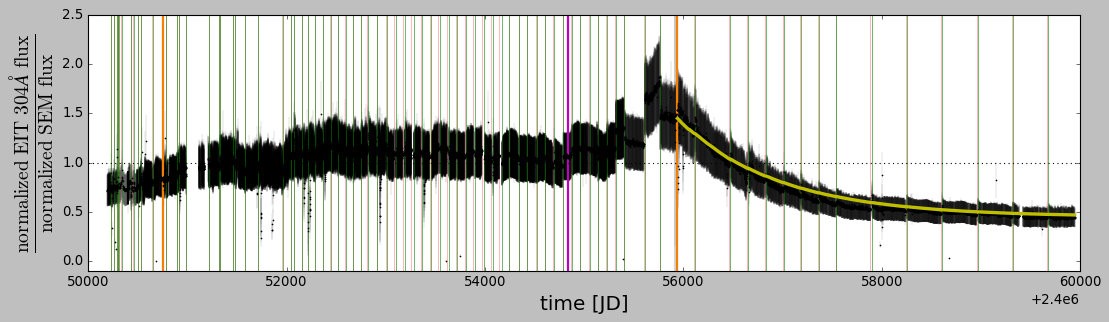

In [55]:
fig, ax = plt.subplots(1,1,figsize=(16,4))
ax.errorbar(t304, ratio, yerr=unc_ratio, color='k', elinewidth=0.1,capsize=0,marker='.',linestyle="None",ms=2)
ax.set_ylim(-0.1,2.5)

for i in range(81):
    bakeoutStartDate = heaterOn[i]['jd']
    bakeoutEndDate = heaterOff[i]['jd']
    ax.axvline(bakeoutStartDate,color='r',linestyle='-',lw=0.5,zorder=1,alpha=0.5)
    ax.axvline(bakeoutEndDate,color='g',linestyle='-',lw=0.5,zorder=2,alpha=1)

ax.set_ylabel(r"$\frac{\mathrm{normalized\ EIT}\ 304\AA\ \mathrm{flux}}{\mathrm{normalized\ SEM\ flux}}$",fontsize=25)
ax.set_xlabel(r"time [JD]", fontsize=18)



xs = np.linspace(0.,4.,7000)
ys = np.exp(-xs)
#ax.plot(1000*xs+2456000, ys+0.45,lw=3,c='y',zorder=10)


ax.plot(t304[t304 >= 2455938], ys[:6907]+0.45, lw=3,c='y',zorder=10)

testRemoveExp = np.ones_like(t304)
testRemoveExp[t304 >= 2455938] = ys[:6907] + 0.45


ax.axvline(2454833,color='m',lw=2)       #Jan 1, 2009.  Bad bakeout discontinuities obvious after this.
ax.axvline(2455938.417,color='#f77f00',lw=2) #Jan 11, 2012. Exponential trend obvious after this.

ax.axvline(2450750,color='#f77f00',lw=2) 


ax.axhline(1,color='k',linestyle=':')


plt.show()


# convolve the above ratio curve with an upside down ricker wavelet to try to identify "snowy" frames

## this is close enough to the shape of the first few solar wind encounters that it might work

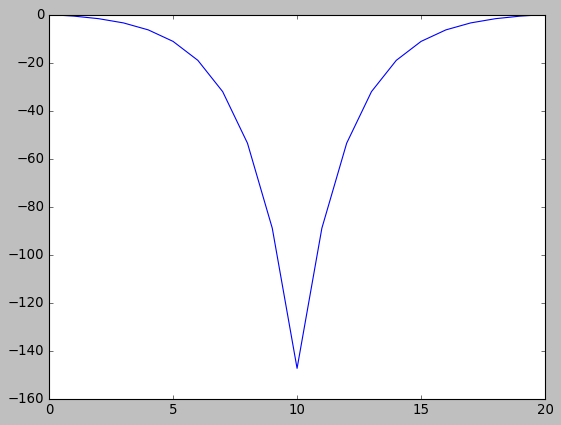

In [109]:
x = np.arange(21)
y = np.zeros(21)
y[0:11] = -np.exp(np.linspace(0,5,11))
y[11:] = y[0:10][::-1]
y=y+1
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(x,y)
plt.show()

33


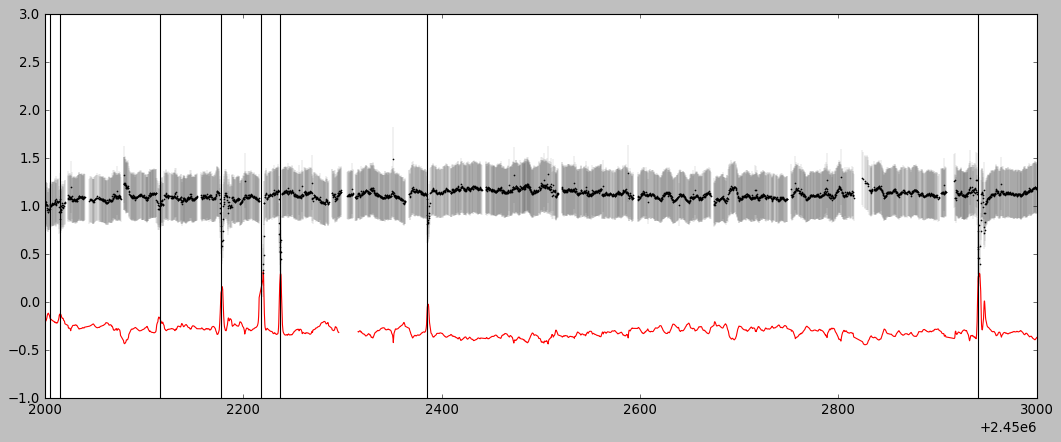

In [214]:
#Okay, there just aren't that many of these. Make a list of times where we see a spike in the convolution
# and then go back and check the SoHO movie theater to make sure it corresponds to a real snow event.

tSus = [2450245, 2450270, 2450398, 2450514, 2450683, 2450925,
       2451706, 2451740, 2451858,
       2452178, 2452218, 2452237, 2452385, 2452941, 2452005, 2452015, 2452116,
       2453388, 2453605, 2453750, 2453320, 2453505,
       2454082, 2454988,
       2455393, 2455950, 2455993,
       2456435, 2456630, 2456665,
       2457981,
       2458005, 2458680,
       ]
tSus = np.array(tSus)
print(len(tSus))

conv = np.convolve(ratio, y, mode='same')

fig, ax = plt.subplots(1,1,figsize=(16,6))
ax.errorbar(t304, ratio, yerr=unc_ratio, color='k', elinewidth=0.1,capsize=0,marker='.',linestyle="None",ms=2)

ax.plot(t304, (conv+500)/500,'r-')
ax.set_xlim(2452000,2453000)
for t in tSus:
    ax.axvline(t,color='k')
ax.set_ylim(-1,3)
plt.show()


(array([  122,   180,   209,   224,   373,   421,   644,  1009,  1207,
        1290,  2218,  2997,  3292,  3727,  3833,  3879,  4233,  4370,
        4561,  4719,  5072,  5285,  5307,  5420,  5481,  5632,  5835,
        5910,  5982,  6347,  6888,  6973,  7207,  7296,  7438,  7713,
        7832,  7850,  8203,  8747,  8911,  9088,  9416,  9715, 10106,
       10854, 11002, 12771, 14148, 14787, 15126, 15208, 15588, 15683,
       15728, 15814, 15984, 16587, 16926, 16962, 17504, 17857, 19062,
       19227, 20430]), {'prominences': array([0.21104397, 0.23220291, 0.1617211 , 0.12447901, 0.1142866 ,
       0.28611462, 0.16770353, 0.44429188, 0.11307479, 0.15249351,
       0.13047241, 0.12677623, 0.11158089, 0.19765411, 0.67740817,
       0.13936375, 0.63871717, 0.11581942, 0.14359303, 0.1336948 ,
       0.18102582, 0.49240996, 0.13452225, 0.6604438 , 0.63604072,
       0.11483541, 0.10684015, 0.16189473, 0.40060184, 0.10428542,
       0.11012916, 0.23144253, 0.15504479, 0.12879529, 0.11188275,
 

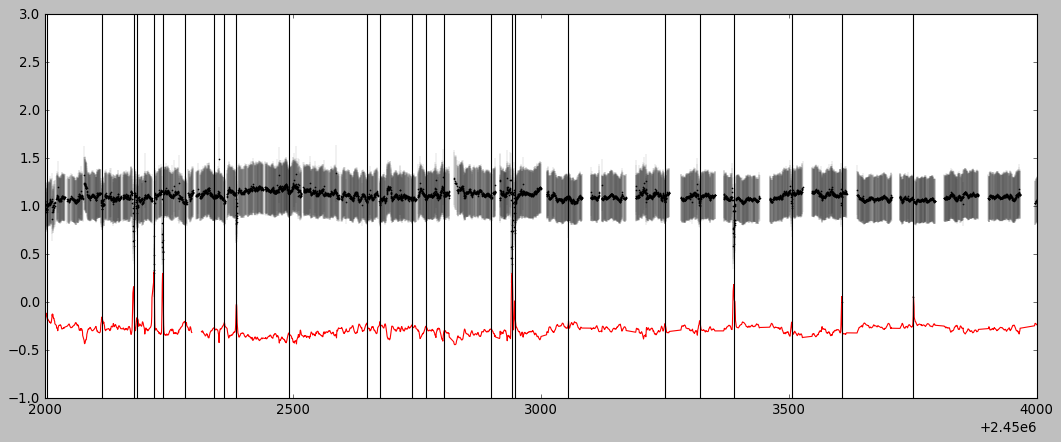

In [225]:
iSus_algo = find_peaks((conv+500)/500, prominence=0.1)
print(iSus_algo)

fig, ax = plt.subplots(1,1,figsize=(16,6))
ax.errorbar(t304, ratio, yerr=unc_ratio, color='k', elinewidth=0.1,capsize=0,marker='.',linestyle="None",ms=2)

ax.plot(t304, (conv+500)/500,'r-')
ax.set_xlim(2452000,2454000)
for i in iSus_algo[0]:
    print(np.round(t304[i], 0))
    ax.axvline(t304[i],color='k')
ax.set_ylim(-1,3)
plt.show()


# Real peaks, selected after looking at frames near the above in the SoHO movie theater and checking for snowy frames

13


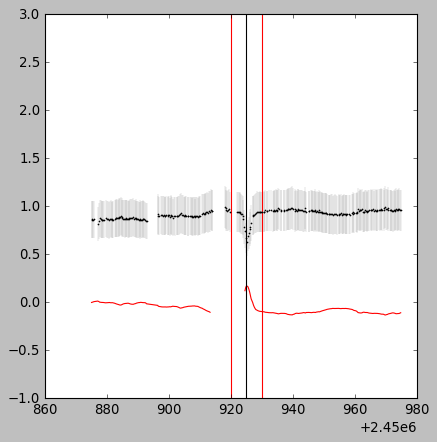

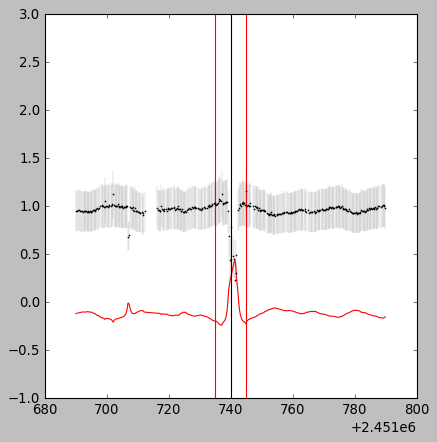

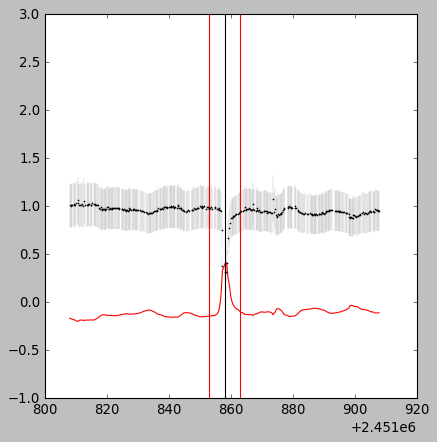

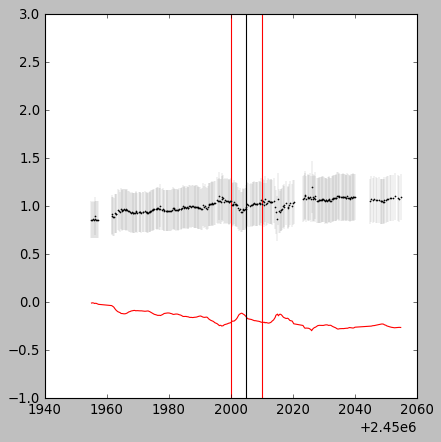

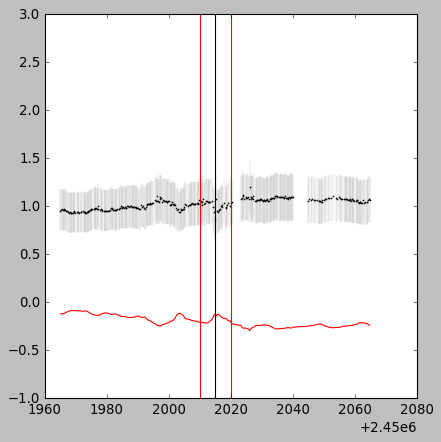

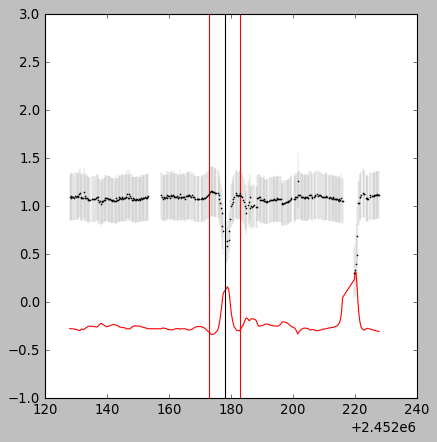

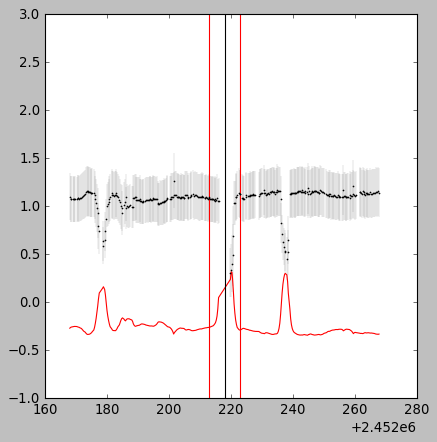

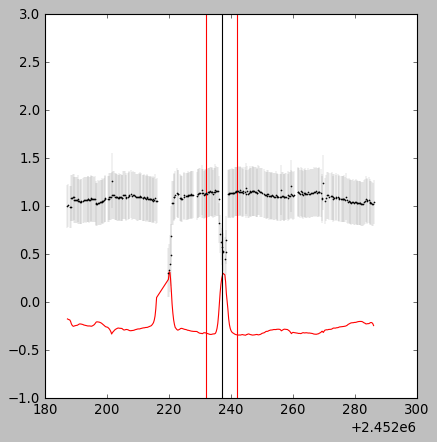

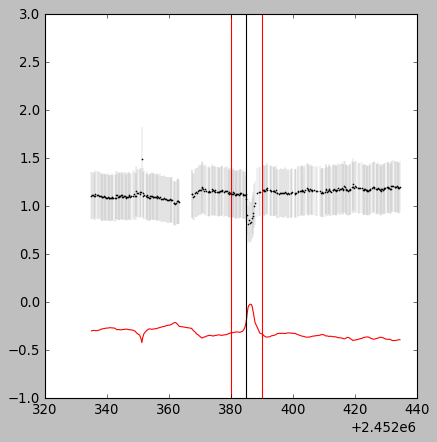

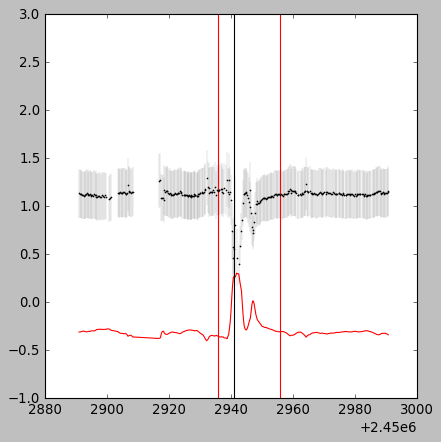

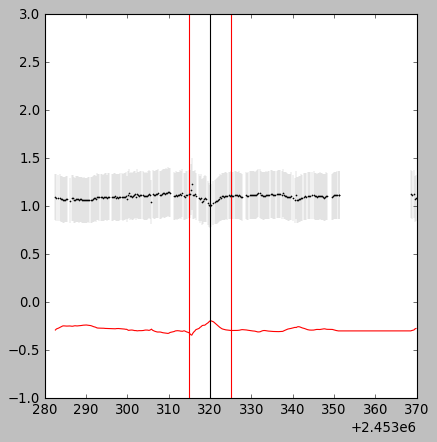

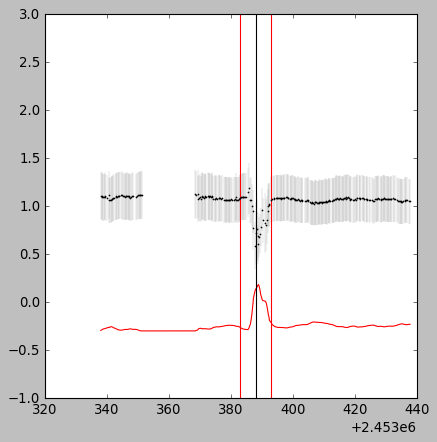

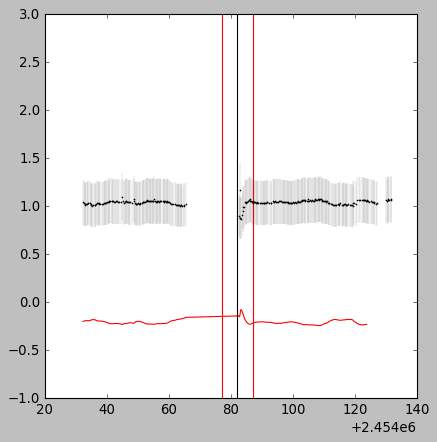

In [232]:
tSnow = [2450925,
       2451740, 2451858,
       2452005, 2452015, 2452178, 2452218, 2452237, 2452385, 2452941, 
       2453320, 2453388,  
       2454082]
tSnow = np.array(tSnow)
print(len(tSnow))

nearSnow = np.zeros_like(ts).astype(bool)

for t in tSnow:
    nearbyMask = (t304 >= t-50 ) & (t304 <= t+50)
    fig, ax = plt.subplots(1,1,figsize=(6,6))
    ax.errorbar(t304[nearbyMask], ratio[nearbyMask], yerr=unc_ratio[nearbyMask], color='k', elinewidth=0.1,capsize=0,marker='.',linestyle="None",ms=2)

    ax.plot(t304[nearbyMask], (conv[nearbyMask]+500)/500,'r-')
    if t == 2452941:
        ax.axvline(t-5, color='r')
        ax.axvline(t, color='k')
        ax.axvline(t+15, color='r')

        nearSnowMask = (ts >= t-5) & (ts <= t+15)

    else:
        ax.axvline(t-5, color='r')
        ax.axvline(t, color='k')
        ax.axvline(t+5, color='r')
        nearSnowMask = (ts >= t-5) & (ts <= t+5)
    
    nearSnow[nearSnowMask] = True
    ax.set_ylim(-1,3)
    plt.show()

